# Inference Testing with Roboflow, Azure & Swiss AI Platform

1. **Roboflow**: Fine-tuned instance segmentation model for detecting objects in images
2. **Azure GPT-4.1**: Multimodal model that can analyze images and respond to text prompts
3. **Swisscom Llama 3.2 Vision**: Another multimodal model capable of analyzing images and text prompts

(same image and similar prompts across all models to compare their responses and capabilities)

In [ ]:
# Load environment variables from .env file
import os
import io
import cv2
import time
import base64
import json
import requests
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from roboflow import Roboflow
from dotenv import load_dotenv
from PIL import Image

# Load environment variables
load_dotenv()

# Check if .env file exists, if not create a placeholder
try:
    with open('.env', 'r') as f:
        env_content = f.read()
    print("Found .env file")
except FileNotFoundError:
    env_content = """
ROBOFLOW_API_KEY=
SWISSCOM_AI_KEY=
SWISSCOM_AI_BASEURL=
SWISSCOM_AI_VISION_MODEL=meta/llama-3.2-90b-vision-instruct
AZURE_URL=
AZURE_API_KEY=
"""
    with open('.env', 'w') as f:
        f.write(env_content.strip())
    print("Created template .env file. Please fill in your API keys!")
    load_dotenv()  # Load again after creating the file

# Define the prompt to use for both text-based models
prompt = "Analyze this image and find RED and GREY marketing poster placeholders. Describe their content, placement, and potential audience."

# Define image path
img_path = "Stellenbilder-no-augs/test/66229_jpg.rf.d4ba322d0570bb4e119115e226dcb558.jpg"

# Create output directory for results if it doesn't exist
os.makedirs("output", exist_ok=True)

# Helper function to display images
def display_image(image_path):
    img = Image.open(image_path)
    plt.figure(figsize=(10, 8))
    plt.imshow(np.array(img))
    plt.axis('off')
    plt.title("Input Image")
    plt.show()
    return img

# Display the input image
try:
    img = display_image(img_path)
    print(f"Image loaded successfully from {img_path}")
except Exception as e:
    print(f"Error loading image: {e}")
    # Try looking in the augmented folder instead
    img_path = "Stellenbilder-no-augs/test/66229_jpg.rf.d4ba322d0570bb4e119115e226dcb558.jpg"
    try:
        img = display_image(img_path)
        print(f"Image loaded successfully from {img_path}")
    except Exception as e:
        print(f"Still could not load image: {e}")
        print("Please ensure the image exists or update the path.")

## 1. Roboflow Model: Instance Segmentation

Using the fine-tuned Roboflow model to detect and segment objects in the image.

In [ ]:
# Get Roboflow API key
roboflow_api_key = os.getenv("ROBOFLOW_API_KEY")

if not roboflow_api_key:
    print("Roboflow API key not found in .env file. Skipping Roboflow model.")
else:
    try:
        from roboflow import Roboflow
        
        # Initialize Roboflow
        rf = Roboflow(api_key=roboflow_api_key)
        
        # Access Roboflow workspace and project
        project = rf.workspace("goldbach-neo-testspace").project("stellenbilder")
        
        # Get the model version
        model = project.version(3).model  # Using version 3 directly
        print(f"Using Roboflow model: {project.name} version 3")
        
        # Make prediction on the image
        print("Running inference with Roboflow SDK...")
        result = model.predict(img_path, confidence=0.4).json()
        
        # Save the raw result
        with open("output/roboflow_result.json", "w") as f:
            json.dump(result, f, indent=2)
        
        # For visualization function
        predictions = result  # This is already in the right format
        
        # Visualize the predictions
        def visualize_predictions(image_path, predictions):
            # Load image
            image = cv2.imread(image_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
            # Drawing parameters
            thickness = 2
            font = cv2.FONT_HERSHEY_SIMPLEX
            font_scale = 0.5
            font_thickness = 1
            colors = {
                "DIG": (255, 0, 0),        # Red
                "F12": (0, 255, 0),       # Green
                "F200": (0, 0, 255),      # Blue
                "F24": (255, 255, 0),     # Yellow
                "F4": (255, 0, 255),      # Magenta
                "Megaposter": (0, 255, 255),  # Cyan
                "default": (128, 128, 128) # Gray for any other class
            }
            
            # Keep track of all classes
            classes_found = set()
            
            # Draw predictions
            for pred in predictions['predictions']:
                # Get class name or default to 'unknown'
                class_name = pred.get('class', 'unknown')
                classes_found.add(class_name)
                confidence = pred.get('confidence', 0)
                
                # Get bounding box
                x = pred.get('x', 0)
                y = pred.get('y', 0)
                width = pred.get('width', 0)
                height = pred.get('height', 0)
                
                # Calculate box coordinates
                x1 = int(x - width/2)
                y1 = int(y - height/2)
                x2 = int(x + width/2)
                y2 = int(y + height/2)
                
                # Get color for class
                color = colors.get(class_name, colors['default'])
                
                # Draw bounding box
                cv2.rectangle(image, (x1, y1), (x2, y2), color, thickness)
                
                # Add label with confidence
                label = f"{class_name}: {confidence:.2f}"
                (label_width, label_height), _ = cv2.getTextSize(label, font, font_scale, font_thickness)
                cv2.rectangle(image, (x1, y1 - label_height - 5), (x1 + label_width, y1), color, -1)
                cv2.putText(image, label, (x1, y1 - 5), font, font_scale, (255, 255, 255), font_thickness)
                
                # Draw mask if available
                if 'points' in pred and isinstance(pred['points'], dict):
                    points = pred['points']
                    for k, point_list in points.items():
                        # Convert points to NumPy array for drawing
                        pts = np.array(point_list, np.int32)
                        pts = pts.reshape((-1, 1, 2))
                        # Draw the polygon
                        cv2.polylines(image, [pts], True, color, 2)
            
            # Create a legend
            legend_y = 30
            for class_name in sorted(classes_found):
                color = colors.get(class_name, colors['default'])
                cv2.rectangle(image, (10, legend_y-15), (25, legend_y), color, -1)
                cv2.putText(image, class_name, (30, legend_y), font, font_scale*1.2, color, font_thickness)
                legend_y += 25
                
            # Display image
            plt.figure(figsize=(12, 10))
            plt.imshow(image)
            plt.axis('off')
            plt.title("Roboflow Instance Segmentation Results")
            plt.tight_layout()
            plt.show()
            
            # Save the visualization
            output_img = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
            cv2.imwrite("output/roboflow_prediction.jpg", output_img)
            print("Saved visualization to output/roboflow_prediction.jpg")
            
            return classes_found
        
        # Visualize and get class information
        classes = visualize_predictions(img_path, predictions)
        print(f"Classes detected: {', '.join(classes)}")
        print(f"Found {len(predictions['predictions'])} objects in the image.")
        
    except Exception as e:
        print(f"Error with Roboflow model: {e}")
        import traceback
        traceback.print_exc()

## 2. Azure GPT-4.1: Multimodal Analysis

In [ ]:
# Get Azure credentials
azure_api_key = os.getenv("AZURE_API_KEY")
azure_url = os.getenv("AZURE_URL") or "https://aihubgptrag0925019255.openai.azure.com/"

# Azure configuration
endpoint = azure_url
model_name = "gpt-4.1"
deployment = "gpt-4.1-workshop"
api_version = "2024-12-01-preview"

if not azure_api_key:
    print("Azure API key not found in .env file. Skipping Azure GPT-4.1 model.")
else:
    try:
        from openai import AzureOpenAI
        
        # Function to encode image to base64
        def encode_image(image_path):
            with open(image_path, "rb") as image_file:
                return base64.b64encode(image_file.read()).decode('utf-8')
        
        # Initialize Azure OpenAI client with the updated parameters
        client = AzureOpenAI(
            api_version=api_version,
            azure_endpoint=endpoint,
            api_key=azure_api_key,
        )
        
        # Encode the image
        base64_image = encode_image(img_path)
        
        # Prepare the message with image and text
        messages = [
            {
                "role": "system",
                "content": "You are a helpful assistant that analyzes images in detail."
            },
            {
                "role": "user",
                "content": [
                    {"type": "text", "text": prompt},
                    {"type": "image_url", "image_url": {"url": f"data:image/jpeg;base64,{base64_image}"}}
                ]
            }
        ]
        
        print("Sending request to Azure GPT-4.1...")
        
        # Call the model using the updated parameters
        response = client.chat.completions.create(
            messages=messages,
            max_completion_tokens=800,  # Changed from max_tokens
            temperature=0.7,
            top_p=1.0,
            frequency_penalty=0.0,
            presence_penalty=0.0,
            model=deployment  # Using the deployment name instead of model
        )
        
        # Print the response
        print("\n===== Azure GPT-4.1 Response =====\n")
        print(response.choices[0].message.content)
        print("\n==================================\n")
        
        # Save the response to a file
        with open("output/azure_gpt4_response.txt", "w") as f:
            f.write(response.choices[0].message.content)
        print("Saved Azure GPT-4.1 response to output/azure_gpt4_response.txt")
        
    except Exception as e:
        print(f"Error with Azure GPT-4.1 model: {e}")
        print("Try checking if the deployment name 'gpt-4.1-workshop' is correct for your Azure account.")

## 3. Swisscom Llama 3.2 Vision: Multimodal Analysis

Using Swisscom's Llama 3.2 vision model to analyze the image with a text prompt.

In [ ]:
# Get Swisscom credentials
swisscom_api_key = os.getenv("SWISSCOM_AI_KEY")
swisscom_base_url = os.getenv("SWISSCOM_AI_BASEURL")
swisscom_vision_model = os.getenv("SWISSCOM_AI_VISION_MODEL", "meta/llama-3.2-90b-vision-instruct")

if not swisscom_api_key or not swisscom_base_url:
    print("Swisscom API key or base URL not found in .env file. Skipping Swisscom Llama 3.2 model.")
else:
    try:
        # Function to convert image to base64
        def image_to_base64(image_path):
            with open(image_path, "rb") as image_file:
                return base64.b64encode(image_file.read()).decode('utf-8')
        
        # Convert our image to base64
        image_base64 = image_to_base64(img_path)
        
        # Prepare the request to Swisscom API
        headers = {
            "Content-Type": "application/json",
            "Authorization": f"Bearer {swisscom_api_key}"
        }
        
        # Using the message format similar to vision_transformation.py
        messages = [
            {
                "role": "user",
                "content": [
                    {"type": "text", "text": prompt},
                    {"type": "image_url", "image_url": {"url": f"data:image/jpeg;base64,{image_base64}"}}
                ]
            }
        ]
        
        # Prepare payload
        payload = {
            "model": swisscom_vision_model,
            "messages": messages,
            "temperature": 0.5,
            "max_tokens": 800,
            "stream": False
        }
        
        print(f"Sending request to Swisscom Llama 3.2 Vision ({swisscom_vision_model})...")
        
        # Call the Swisscom API
        response = requests.post(
            f"{swisscom_base_url}/chat/completions",
            headers=headers,
            json=payload
        )
        
        # Check if the request was successful
        if response.status_code == 200:
            response_data = response.json()
            llama_response = response_data['choices'][0]['message']['content']
            
            # Print the response
            print("\n===== Swisscom Llama 3.2 Response =====\n")
            print(llama_response)
            print("\n==================================\n")
            
            # Save the response to a file
            with open("output/swisscom_llama_response.txt", "w") as f:
                f.write(llama_response)
            print("Saved Swisscom Llama 3.2 response to output/swisscom_llama_response.txt")
            
            # Print token usage if available
            if 'usage' in response_data:
                usage = response_data['usage']
                print(f"Token usage: {usage.get('total_tokens', 'N/A')} total tokens ")
                print(f"({usage.get('prompt_tokens', 'N/A')} prompt, {usage.get('completion_tokens', 'N/A')} completion)")
        else:
            print(f"Error: Received status code {response.status_code} from Swisscom API")
            print(f"Response: {response.text}")
            
    except Exception as e:
        print(f"Error with Swisscom Llama 3.2 model: {e}")

## Model Comparison and Analysis

1. **Roboflow** provides localization and classification of objects through instance segmentation.
2. **Azure GPT-4.1** offers detailed text analysis and understanding of the image content.
3. **Swisscom Llama 3.2** provides another perspective on image analysis with potentially different capabilities.

In [ ]:
try:
    azure_response = ""
    llama_response = ""
    
    # Try to load Azure response
    try:
        with open("output/azure_gpt4_response.txt", "r") as f:
            azure_response = f.read()
    except FileNotFoundError:
        azure_response = "Azure GPT-4.1 response not available"
    
    # Try to load Swisscom response
    try:
        with open("output/swisscom_llama_response.txt", "r") as f:
            llama_response = f.read()
    except FileNotFoundError:
        llama_response = "Swisscom Llama 3.2 response not available"
    
    # Create a side-by-side comparison in markdown
    from IPython.display import Markdown, display
    
    comparison_md = """
    # Response Comparison
    
    | Azure GPT-4.1 | Swisscom Llama 3.2 |
    |---------------|--------------------|
    | {} | {} |
    """.format(azure_response.replace('\n', '<br>'), llama_response.replace('\n', '<br>'))
    
    display(Markdown(comparison_md))
    
    # Save comparison to a file
    with open("output/model_comparison.md", "w") as f:
        f.write(comparison_md)
    print("Saved comparison to output/model_comparison.md")
    
except Exception as e:
    print(f"Error creating comparison: {e}")

## 4. Systematic Comparison: Classification and Location Extraction

Analyzes multiple images from our test set using both GPT-4.1 and Llama 3.2 models to:

1. Detect red and grey marketing poster placeholders
2. Extract their locations
3. Generate structured output
4. Compare the results between models

In [ ]:
# Create a structured prompt for both models
structured_prompt = """
Analyze this image and identify all RED and GREY marketing poster placeholders.

Provide your answer in the following JSON format only:
{
    "red_placeholders": {
        "count": <number of red placeholders>,
        "locations": ["<description of location 1>", "<description of location 2>", ...]
    },
    "grey_placeholders": {
        "count": <number of grey placeholders>,
        "locations": ["<description of location 1>", "<description of location 2>", ...]
    },
    "has_red_placeholder": <true/false>,
    "has_grey_placeholder": <true/false>
}

Be sure to accurately count the placeholders and describe their relative positions in the image (e.g., "top left", "bottom right", "center", etc.). Only include placeholders that are clearly visible in the image.
"""

# Extract JSON from model responses with error handling
def extract_json_from_response(text):
    # Try to find JSON content between triple backticks
    import re
    import json
    
    # Try the most common formats
    json_patterns = [
        r'```json\s*({.*?})\s*```',  # JSON with json tag
        r'```\s*({.*?})\s*```',      # JSON with just backticks
        r'{\s*"red_placeholders".*?}\s*}(?=\s|$)',  # Raw JSON pattern
    ]
    
    # Try each pattern
    for pattern in json_patterns:
        matches = re.findall(pattern, text, re.DOTALL)
        if matches:
            try:
                return json.loads(matches[0])
            except json.JSONDecodeError:
                continue
    
    # If no pattern worked, try to extract the entire JSON object
    try:
        # Find the opening brace
        start_idx = text.find('{')
        if start_idx != -1:
            # Count opening and closing braces to find the matching closing brace
            brace_count = 0
            for i in range(start_idx, len(text)):
                if text[i] == '{':
                    brace_count += 1
                elif text[i] == '}':
                    brace_count -= 1
                    if brace_count == 0:
                        # Found matching closing brace
                        json_str = text[start_idx:i+1]
                        return json.loads(json_str)
    except:
        pass
    
    # Last resort: default values if parsing fails
    print("Could not extract JSON from response, using default values")
    return {
        "red_placeholders": {"count": 0, "locations": []},
        "grey_placeholders": {"count": 0, "locations": []},
        "has_red_placeholder": False,
        "has_grey_placeholder": False,
        "parsing_error": True
    }

# Process a single image with both models and return structured results
def process_image_with_models(image_path, azure_client, swisscom_api_key, swisscom_base_url, swisscom_vision_model):
    print(f"Processing {image_path}...")
    
    # Image base64 encoding (shared between models)
    base64_image = encode_image(image_path)
    
    results = {}
    
    # 1. Azure GPT-4.1
    if azure_client is not None:
        try:
            # Prepare the message with image and text
            messages = [
                {"role": "system", "content": "You are a specialized computer vision assistant that only responds in JSON format."},
                {
                    "role": "user",
                    "content": [
                        {"type": "text", "text": structured_prompt},
                        {"type": "image_url", "image_url": {"url": f"data:image/jpeg;base64,{base64_image}"}}
                    ]
                }
            ]
            
            # Call the model
            response = azure_client.chat.completions.create(
                messages=messages,
                max_completion_tokens=800,
                temperature=0.3,  # Lower temperature for more deterministic outputs
                top_p=1.0,
                frequency_penalty=0.0,
                presence_penalty=0.0,
                model=deployment
            )
            
            # Extract JSON from response
            gpt4_text = response.choices[0].message.content
            results['gpt4'] = {
                'raw_response': gpt4_text,
                'parsed': extract_json_from_response(gpt4_text)
            }
            
        except Exception as e:
            print(f"Error with Azure GPT-4.1 on {image_path}: {e}")
            results['gpt4'] = {
                'raw_response': f"Error: {str(e)}",
                'parsed': {
                    "red_placeholders": {"count": 0, "locations": []},
                    "grey_placeholders": {"count": 0, "locations": []},
                    "has_red_placeholder": False,
                    "has_grey_placeholder": False,
                    "error": str(e)
                }
            }
    
    # 2. Swisscom Llama 3.2
    if swisscom_api_key and swisscom_base_url:
        try:
            # Prepare the request to Swisscom API
            headers = {
                "Content-Type": "application/json",
                "Authorization": f"Bearer {swisscom_api_key}"
            }
            
            # Using the message format
            messages = [
                {"role": "system", "content": "You are a specialized computer vision assistant that only responds in JSON format."},
                {
                    "role": "user",
                    "content": [
                        {"type": "text", "text": structured_prompt},
                        {"type": "image_url", "image_url": {"url": f"data:image/jpeg;base64,{base64_image}"}}
                    ]
                }
            ]
            
            # Prepare payload
            payload = {
                "model": swisscom_vision_model,
                "messages": messages,
                "temperature": 0.3,  # Lower temperature for more deterministic outputs
                "max_tokens": 800,
                "stream": False
            }
            
            # Call the Swisscom API
            response = requests.post(
                f"{swisscom_base_url}/chat/completions",
                headers=headers,
                json=payload
            )
            
            # Check if the request was successful
            if response.status_code == 200:
                response_data = response.json()
                llama_text = response_data['choices'][0]['message']['content']
                results['llama'] = {
                    'raw_response': llama_text,
                    'parsed': extract_json_from_response(llama_text)
                }
            else:
                raise Exception(f"Status code: {response.status_code}, Response: {response.text}")
                
        except Exception as e:
            print(f"Error with Swisscom Llama 3.2 on {image_path}: {e}")
            results['llama'] = {
                'raw_response': f"Error: {str(e)}",
                'parsed': {
                    "red_placeholders": {"count": 0, "locations": []},
                    "grey_placeholders": {"count": 0, "locations": []},
                    "has_red_placeholder": False,
                    "has_grey_placeholder": False,
                    "error": str(e)
                }
            }
    
    return results

In [ ]:
# Process all test images and collect results
azure_client = None
if azure_api_key:
    try:
        from openai import AzureOpenAI
        # Initialize Azure OpenAI client
        azure_client = AzureOpenAI(
            api_version=api_version,
            azure_endpoint=endpoint,
            api_key=azure_api_key,
        )
        print("Azure client initialized successfully")
    except Exception as e:
        print(f"Error initializing Azure client: {e}")

# Create output directory for comparative results
os.makedirs("output/comparison", exist_ok=True)

# Get all test images
import glob
test_images = glob.glob("Stellenbilder-no-augs/test/*.jpg")
print(f"Found {len(test_images)} test images")

# Process each image with both models and collect results
comparison_results = []

# For demo purposes, limit to a few images if needed
max_images = 5  # You can increase this or set to None for all images
if max_images:
    test_images = test_images[:max_images]
    print(f"Processing {len(test_images)} images for demonstration")

# Process each image
all_results = {}
for img_path in test_images:
    # Extract image name from path
    img_name = os.path.basename(img_path)
    
    # Process the image with both models
    results = process_image_with_models(
        img_path, 
        azure_client, 
        swisscom_api_key, 
        swisscom_base_url, 
        swisscom_vision_model
    )
    
    # Store results
    all_results[img_name] = results
    
    # Add to comparison table
    if 'gpt4' in results:
        gpt4_data = results['gpt4']['parsed']
        comparison_results.append({
            'image': img_name,
            'model': 'GPT-4.1',
            'red_count': gpt4_data['red_placeholders']['count'],
            'grey_count': gpt4_data['grey_placeholders']['count'],
            'has_red': gpt4_data['has_red_placeholder'],
            'has_grey': gpt4_data['has_grey_placeholder'],
            'red_locations': ', '.join(gpt4_data['red_placeholders']['locations']),
            'grey_locations': ', '.join(gpt4_data['grey_placeholders']['locations'])
        })
    
    if 'llama' in results:
        llama_data = results['llama']['parsed']
        comparison_results.append({
            'image': img_name,
            'model': 'Llama 3.2',
            'red_count': llama_data['red_placeholders']['count'],
            'grey_count': llama_data['grey_placeholders']['count'],
            'has_red': llama_data['has_red_placeholder'],
            'has_grey': llama_data['has_grey_placeholder'],
            'red_locations': ', '.join(llama_data['red_placeholders']['locations']),
            'grey_locations': ', '.join(llama_data['grey_placeholders']['locations'])
        })

# Save raw results to file
with open('output/comparison/raw_results.json', 'w') as f:
    json.dump(all_results, f, indent=2)

print(f"Processed {len(test_images)} images with both models")
print(f"Results saved to output/comparison/raw_results.json")

# Create comparison DataFrame
import pandas as pd
df_comparison = pd.DataFrame(comparison_results)

# Save comparison to CSV
df_comparison.to_csv('output/comparison/model_comparison.csv', index=False)

# Display the comparison table
from IPython.display import display
print("\nComparison Table:")
display(df_comparison)

In [ ]:
# Visualize the comparison results

# 1. Create a grouped bar chart for count comparison
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style
sns.set(style="whitegrid")
plt.figure(figsize=(16, 10))

# Reshape data for easier plotting
model_counts = pd.DataFrame()

# Group by image and model, then calculate counts
for img in df_comparison['image'].unique():
    img_data = df_comparison[df_comparison['image'] == img]
    
    # Get data for each model
    for model in img_data['model'].unique():
        model_data = img_data[img_data['model'] == model]
        
        # Add to the dataframe
        model_counts = pd.concat([model_counts, pd.DataFrame({
            'Image': [img],
            'Model': [model],
            'Red Placeholders': [model_data['red_count'].values[0]],
            'Grey Placeholders': [model_data['grey_count'].values[0]]
        })], ignore_index=True)

# Reshape data for seaborn
model_counts_melted = pd.melt(
    model_counts, 
    id_vars=['Image', 'Model'], 
    value_vars=['Red Placeholders', 'Grey Placeholders'],
    var_name='Placeholder Type', 
    value_name='Count'
)

# Create the grouped bar chart
plt.figure(figsize=(16, 8))
sns.barplot(
    data=model_counts_melted,
    x='Image',
    y='Count',
    hue='Placeholder Type',
    palette=['darkred', 'darkgrey'],
    errorbar=None,
    alpha=0.8
)

# Add a second grouping by model
n_images = len(model_counts['Image'].unique())
n_models = len(model_counts['Model'].unique())
model_offsets = np.linspace(-0.2, 0.2, n_models)

# Highlight model differences with patterns
for i, (img, img_group) in enumerate(model_counts_melted.groupby('Image')):
    for j, (model, model_group) in enumerate(img_group.groupby('Model')):
        for k, (placeholder_type, type_group) in enumerate(model_group.groupby('Placeholder Type')):
            # Add a model indicator
            pattern = '//' if model == 'GPT-4.1' else 'xx'
            plt.annotate(
                model,
                xy=(i + model_offsets[j], type_group['Count'].values[0] + 0.1),
                xytext=(0, 5),
                textcoords='offset points',
                ha='center',
                fontsize=8,
                rotation=90,
                color='black' if model == 'GPT-4.1' else 'darkblue'
            )

# Customize the plot
plt.title('Comparison of Placeholder Counts: GPT-4.1 vs Llama 3.2', fontsize=16)
plt.xlabel('Image', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Placeholder Type', fontsize=12)
plt.tight_layout()

# Save the plot
plt.savefig('output/comparison/placeholder_counts.png', dpi=300, bbox_inches='tight')
plt.show()

# 2. Create a heatmap to compare model agreement
plt.figure(figsize=(14, 8))

# Calculate agreement matrix
agreement_data = []

for img in df_comparison['image'].unique():
    img_data = df_comparison[df_comparison['image'] == img]
    
    # Get data for each model
    gpt_data = img_data[img_data['model'] == 'GPT-4.1']
    llama_data = img_data[img_data['model'] == 'Llama 3.2']
    
    if not gpt_data.empty and not llama_data.empty:
        # Calculate difference metrics
        red_diff = abs(gpt_data['red_count'].values[0] - llama_data['red_count'].values[0])
        grey_diff = abs(gpt_data['grey_count'].values[0] - llama_data['grey_count'].values[0])
        
        # Red placeholder agreement (boolean)
        red_bool_agreement = gpt_data['has_red'].values[0] == llama_data['has_red'].values[0]
        
        # Grey placeholder agreement (boolean)
        grey_bool_agreement = gpt_data['has_grey'].values[0] == llama_data['has_grey'].values[0]
        
        # Overall agreement score (lower is better)
        agreement_score = red_diff + grey_diff + (0 if red_bool_agreement else 1) + (0 if grey_bool_agreement else 1)
        
        agreement_data.append({
            'Image': img,
            'Red Count Diff': red_diff,
            'Grey Count Diff': grey_diff,
            'Red Bool Agreement': red_bool_agreement,
            'Grey Bool Agreement': grey_bool_agreement,
            'Agreement Score': agreement_score
        })

# Create DataFrame for heatmap
df_agreement = pd.DataFrame(agreement_data)

# Pivot for heatmap format
heatmap_data = df_agreement.set_index('Image')[['Red Count Diff', 'Grey Count Diff', 'Agreement Score']]

# Create heatmap
plt.figure(figsize=(12, len(heatmap_data) * 0.8))
sns.heatmap(
    heatmap_data, 
    annot=True, 
    cmap='RdYlGn_r',  # Reversed so red means more disagreement
    linewidths=0.5,
    fmt=".0f")

plt.title('Model Agreement Heatmap (Lower = Better Agreement)', fontsize=16)
plt.tight_layout()

# Save the plot
plt.savefig('output/comparison/model_agreement.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# Create visualizations with actual images and model annotations

# Function to draw placeholder annotations on images
def draw_annotations(image_path, model_results, model_name):
    # Load and convert image
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Create a copy for drawing
    annotated_img = img.copy()
    
    # Get image dimensions
    h, w, _ = img.shape
    
    # Font settings
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 0.7
    font_thickness = 2
    
    # Add title
    cv2.putText(
        annotated_img, 
        f"{model_name} Analysis", 
        (10, 30), 
        font, 
        1, 
        (255, 255, 255), 
        font_thickness + 1
    )
    
    # Draw a semitransparent overlay for the legend
    overlay = annotated_img.copy()
    cv2.rectangle(overlay, (10, 40), (300, 120), (0, 0, 0), -1)
    cv2.addWeighted(overlay, 0.5, annotated_img, 0.5, 0, annotated_img)
    
    # Add legend
    legend_y = 70
    cv2.putText(annotated_img, f"Red placeholders: {model_results['red_placeholders']['count']}", 
                (20, legend_y), font, font_scale, (255, 50, 50), font_thickness)
    legend_y += 30
    cv2.putText(annotated_img, f"Grey placeholders: {model_results['grey_placeholders']['count']}", 
                (20, legend_y), font, font_scale, (180, 180, 180), font_thickness)
    
    # Draw approximate locations based on text descriptions (this is simplified)
    # Map common location terms to image coordinates (as ratios of image dimensions)
    location_map = {
        'top left': (0.25, 0.25),
        'top right': (0.75, 0.25),
        'bottom left': (0.25, 0.75),
        'bottom right': (0.75, 0.75),
        'top': (0.5, 0.25),
        'bottom': (0.5, 0.75),
        'left': (0.25, 0.5),
        'right': (0.75, 0.5),
        'center': (0.5, 0.5),
        'middle': (0.5, 0.5),
        'upper left': (0.25, 0.25),
        'upper right': (0.75, 0.25),
        'lower left': (0.25, 0.75),
        'lower right': (0.75, 0.75),
    }
    
    # Helper function to guess position from text description
    def guess_position(location_text, fallback=(0.5, 0.5)):
        location_text = location_text.lower()
        for key, pos in location_map.items():
            if key in location_text:
                return pos
        return fallback
    
    # Draw red placeholder annotations
    for location in model_results['red_placeholders']['locations']:
        rx, ry = guess_position(location)
        center_x, center_y = int(rx * w), int(ry * h)
        # Draw a red circle for red placeholders
        cv2.circle(annotated_img, (center_x, center_y), 40, (255, 0, 0), 3)
        # Add a small label
        cv2.putText(annotated_img, "R", (center_x-8, center_y+8), 
                   font, font_scale, (255, 0, 0), font_thickness)
    
    # Draw grey placeholder annotations
    for location in model_results['grey_placeholders']['locations']:
        gx, gy = guess_position(location)
        center_x, center_y = int(gx * w), int(gy * h)
        # Draw a grey circle for grey placeholders
        cv2.circle(annotated_img, (center_x, center_y), 40, (169, 169, 169), 3)
        # Add a small label
        cv2.putText(annotated_img, "G", (center_x-8, center_y+8), 
                   font, font_scale, (169, 169, 169), font_thickness)
    
    return annotated_img

# Create side-by-side comparisons for a few example images
def create_side_by_side_comparison(img_path, gpt_results, llama_results):
    # Draw annotations
    gpt_img = draw_annotations(img_path, gpt_results, "GPT-4.1")
    llama_img = draw_annotations(img_path, llama_results, "Llama 3.2")
    
    # Create side-by-side image
    comparison = np.hstack((gpt_img, llama_img))
    
    return comparison

# Create a grid of comparisons for visualization
fig, axes = plt.subplots(len(test_images), 1, figsize=(20, 8 * len(test_images)))
if len(test_images) == 1:
    axes = [axes]  # Make it indexable if only one image

for i, img_path in enumerate(test_images):
    img_name = os.path.basename(img_path)
    img_results = all_results[img_name]
    
    if 'gpt4' in img_results and 'llama' in img_results:
        gpt_results = img_results['gpt4']['parsed']
        llama_results = img_results['llama']['parsed']
        
        # Create comparison image
        comparison = create_side_by_side_comparison(img_path, gpt_results, llama_results)
        
        # Display in the grid
        axes[i].imshow(comparison)
        axes[i].set_title(f"Image: {img_name}", fontsize=16)
        axes[i].axis('off')

# Adjust layout and save
plt.tight_layout()
plt.savefig('output/comparison/visual_comparison.png', dpi=200, bbox_inches='tight')
plt.show()

In [ ]:
# Create summary visualizations and conclusions

# 1. Create a summary bar chart comparing model accuracy
plt.figure(figsize=(12, 6))

# Prepare data for summary
summary_data = []
for model in ['GPT-4.1', 'Llama 3.2']:
    model_df = df_comparison[df_comparison['model'] == model]
    
    total_red = model_df['red_count'].sum()
    total_grey = model_df['grey_count'].sum()
    
    summary_data.append({
        'Model': model,
        'Red Placeholders': total_red,
        'Grey Placeholders': total_grey,
        'Total Placeholders': total_red + total_grey
    })

# Create DataFrame
df_summary = pd.DataFrame(summary_data)

# Plot the summary
summary_melted = pd.melt(
    df_summary,
    id_vars=['Model'],
    value_vars=['Red Placeholders', 'Grey Placeholders', 'Total Placeholders'],
    var_name='Placeholder Type',
    value_name='Count'
)

sns.barplot(
    data=summary_melted,
    x='Model',
    y='Count',
    hue='Placeholder Type',
    palette=['darkred', 'darkgrey', 'darkblue'],
    errorbar=None
)

plt.title('Total Placeholder Counts by Model', fontsize=16)
plt.xlabel('Model', fontsize=14)
plt.ylabel('Total Count', fontsize=14)
plt.legend(title='Placeholder Type')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Save the summary plot
plt.savefig('output/comparison/model_summary.png', dpi=300, bbox_inches='tight')
plt.show()

# 2. Calculate agreement rate between models
model_agreement = []
for img in df_comparison['image'].unique():
    img_data = df_comparison[df_comparison['image'] == img]
    
    if len(img_data) >= 2:  # Make sure we have both models
        gpt_data = img_data[img_data['model'] == 'GPT-4.1'].iloc[0]
        llama_data = img_data[img_data['model'] == 'Llama 3.2'].iloc[0]
        
        # Check agreement on has_red and has_grey
        red_agreement = gpt_data['has_red'] == llama_data['has_red']
        grey_agreement = gpt_data['has_grey'] == llama_data['has_grey']
        
        # Check agreement on counts (within ±1 tolerance)
        red_count_agreement = abs(gpt_data['red_count'] - llama_data['red_count']) <= 1
        grey_count_agreement = abs(gpt_data['grey_count'] - llama_data['grey_count']) <= 1
        
        model_agreement.append({
            'Image': img,
            'Red Detection Agreement': red_agreement,
            'Grey Detection Agreement': grey_agreement,
            'Red Count Agreement': red_count_agreement,
            'Grey Count Agreement': grey_count_agreement
        })

# Create agreement DataFrame
df_agreement_summary = pd.DataFrame(model_agreement)

# Calculate overall agreement percentages
agreement_percentages = {
    'Red Detection': df_agreement_summary['Red Detection Agreement'].mean() * 100,
    'Grey Detection': df_agreement_summary['Grey Detection Agreement'].mean() * 100,
    'Red Count': df_agreement_summary['Red Count Agreement'].mean() * 100,
    'Grey Count': df_agreement_summary['Grey Count Agreement'].mean() * 100
}

# Plot agreement percentages
plt.figure(figsize=(10, 6))
sns.barplot(
    x=list(agreement_percentages.keys()),
    y=list(agreement_percentages.values()),
    palette='Blues_d'
)

# Add percentage labels
for i, p in enumerate(plt.gca().patches):
    plt.text(
        p.get_x() + p.get_width()/2.,
        p.get_height() + 1,
        f'{agreement_percentages[list(agreement_percentages.keys())[i]]:.1f}%',
        ha="center", fontsize=12
    )

plt.title('Agreement Between GPT-4.1 and Llama 3.2', fontsize=16)
plt.xlabel('Agreement Type', fontsize=14)
plt.ylabel('Agreement Percentage', fontsize=14)
plt.ylim(0, 105)  # Set y-axis limit to accommodate the labels
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Save the agreement plot
plt.savefig('output/comparison/model_agreement_percentages.png', dpi=300, bbox_inches='tight')
plt.show()

# 3. Generate a summary table with key findings
print("\nModel Comparison Summary:")

# Create a DataFrame for key metrics
key_metrics = [
    {'Metric': 'Total Red Placeholders Detected', 
     'GPT-4.1': df_comparison[df_comparison['model'] == 'GPT-4.1']['red_count'].sum(),
     'Llama 3.2': df_comparison[df_comparison['model'] == 'Llama 3.2']['red_count'].sum()},
    {'Metric': 'Total Grey Placeholders Detected',
     'GPT-4.1': df_comparison[df_comparison['model'] == 'GPT-4.1']['grey_count'].sum(),
     'Llama 3.2': df_comparison[df_comparison['model'] == 'Llama 3.2']['grey_count'].sum()},
    {'Metric': 'Images with Red Placeholders',
     'GPT-4.1': df_comparison[df_comparison['model'] == 'GPT-4.1']['has_red'].sum(),
     'Llama 3.2': df_comparison[df_comparison['model'] == 'Llama 3.2']['has_red'].sum()},
    {'Metric': 'Images with Grey Placeholders',
     'GPT-4.1': df_comparison[df_comparison['model'] == 'GPT-4.1']['has_grey'].sum(),
     'Llama 3.2': df_comparison[df_comparison['model'] == 'Llama 3.2']['has_grey'].sum()}]

# Create summary DataFrame, display and save
df_key_metrics = pd.DataFrame(key_metrics)
display(df_key_metrics)
df_key_metrics.to_csv('output/comparison/key_metrics.csv', index=False)
print("\nResults and visualizations have been saved to the 'output/comparison' directory.")

## 6. Filling Placeholders with Generated Content

In [ ]:
def fill_placeholders_with_seg_and_dalle(
    img_path: str,
    prompt: str,
    dalle_deployment: str,
    api_version: str = "2024-02-01",
    confidence: float = 0.4
) -> None:
    """
    1) Runs Roboflow instance segmentation on img_path
    2) For each detected mask or polygon, generates a DALL·E patch via Azure
    3) Pastes each patch into the original, respecting the region shape
    4) Displays and saves the composited image
    """
    # ─── 1. Run Roboflow inference ─────────────
    rf_key = os.getenv("ROBOFLOW_API_KEY")
    if not rf_key:
        raise EnvironmentError("ROBOFLOW_API_KEY not set")

    rf = Roboflow(api_key=rf_key)
    project = rf.workspace("goldbach-neo-testspace").project("stellenbilder")
    model   = project.version(3).model

    raw   = model.predict(img_path, confidence=confidence).json()
    preds = raw.get("predictions", [])
    if not preds:
        print("No placeholders detected; nothing to fill.")
        return

    print(f"Detected {len(preds)} placeholders")

    # Load original image as RGBA
    orig_bgr = cv2.imread(img_path)
    orig_rgb = cv2.cvtColor(orig_bgr, cv2.COLOR_BGR2RGB)
    h, w, _  = orig_rgb.shape
    canvas   = Image.fromarray(orig_rgb).convert("RGBA")

    # Prepare DALL·E headers
    dalle_key = os.getenv("AZURE_API_KEY_DALLE")
    dalle_url = os.getenv("AZURE_URL_DALLE")
    if not dalle_key or not dalle_url:
        raise EnvironmentError("AZURE_API_KEY_DALLE and AZURE_URL_DALLE must be set")

    headers = {
        "Authorization": f"Bearer {dalle_key}",
        "Content-Type":  "application/json"
    }
    gen_endpoint = (
        f"{dalle_url.rstrip('/')}/openai/deployments/"
        f"{dalle_deployment}/images/generations?api-version={api_version}"
    )

    # ─── 2. Process each prediction ────────────
    for idx, pred in enumerate(preds, 1):
        # 2a) Build a binary mask for this region
        mask_np = np.zeros((h, w), dtype=np.uint8)

        if pred.get("mask"):
            # if Roboflow returned an encoded mask
            mask_bytes = base64.b64decode(pred["mask"])
            mask_img   = Image.open(io.BytesIO(mask_bytes)).convert("L")
            mask_np    = np.array(mask_img)

        elif pred.get("points") and isinstance(pred["points"], list):
            # Roboflow here returns a list of point dicts
            pts = np.array(
                [[p["x"], p["y"]] for p in pred["points"]],
                dtype=np.int32
            ).reshape(-1,1,2)
            cv2.fillPoly(mask_np, [pts], 255)

        else:
            # fallback to bbox
            cx, cy, bw, bh = pred["x"], pred["y"], pred["width"], pred["height"]
            x1 = int(cx - bw/2);  y1 = int(cy - bh/2)
            x2 = x1 + int(bw);    y2 = y1 + int(bh)
            cv2.rectangle(mask_np, (x1, y1), (x2, y2), 255, -1)

        # 2b) Get bounding rect of mask
        contours, _ = cv2.findContours(mask_np, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if not contours:
            print(f"  – skipped placeholder #{idx}: no valid mask")
            continue

        x1, y1, bw, bh = cv2.boundingRect(max(contours, key=cv2.contourArea))
        x2, y2 = x1 + bw, y1 + bh

        print(f"[{idx}/{len(preds)}] Generating patch at ({x1},{y1}) {bw}×{bh}")

        # 2c) Call DALL·E to generate a square patch, then resize
        payload = {
            "prompt": prompt,
            "size":   "1024x1024",
            "n":      1,
            "style":  "vivid",
            "quality":"standard"
        }
        resp = requests.post(gen_endpoint, headers=headers, json=payload)
        resp.raise_for_status()
        patch_url = resp.json()["data"][0]["url"]

        patch = Image.open(io.BytesIO(requests.get(patch_url).content))
        patch = patch.resize((bw, bh), Image.LANCZOS).convert("RGBA")

        # 2d) Paste with mask crop
        mask_crop = mask_np[y1:y2, x1:x2]
        mask_img  = Image.fromarray(mask_crop).convert("L")
        canvas.paste(patch, (x1, y1), mask_img)

        # throttle to reduce rate hits
        time.sleep(1.0)

    # ─── 3. Show & save ───────────────────────
    plt.figure(figsize=(12,10))
    plt.imshow(canvas)
    plt.axis("off")
    plt.title("Filled placeholders via Segmentation + DALL·E")
    plt.tight_layout()
    plt.show()

    out_file = "output/filled_with_segmentation.png"
    os.makedirs(os.path.dirname(out_file), exist_ok=True)
    canvas.convert("RGB").save(out_file)
    print(f"Saved result to {out_file}")


loading Roboflow workspace...
loading Roboflow project...
Detected 2 placeholders
[1/2] Generating patch at (985,481) 83×226
[2/2] Generating patch at (878,477) 108×237


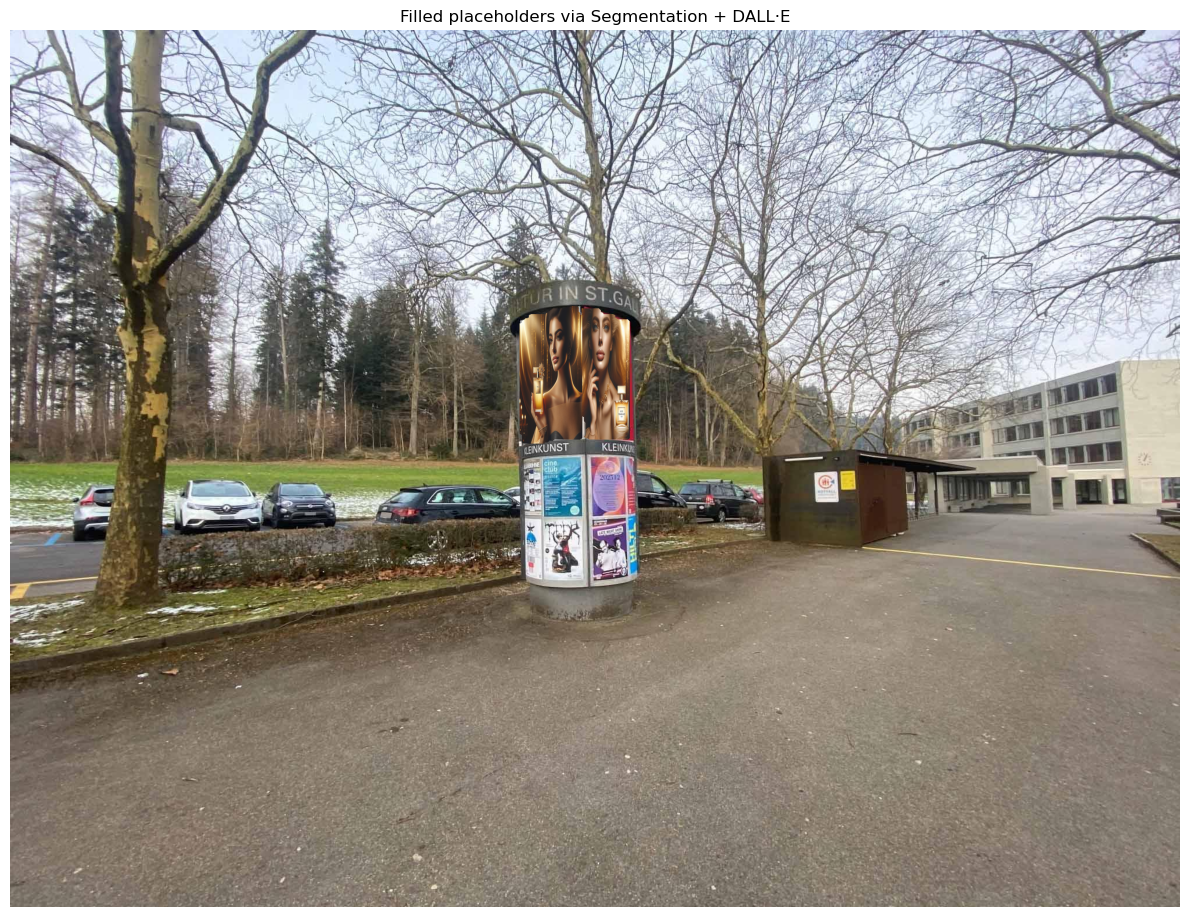

Saved result to output/filled_with_segmentation.png


In [8]:
fill_placeholders_with_seg_and_dalle(
    img_path          = "Stellenbilder-no-augs/test/66229_jpg.rf.d4ba322d0570bb4e119115e226dcb558.jpg",
    prompt            = "A luxury perfume advertisement for 'Gold Fragrance Neo', elegant woman in soft golden lighting",
    dalle_deployment  = "dall-e-3-workshop",
    api_version       = "2024-02-01",
    confidence        = 0.6
)